# Introduction

The state of Iowa provides many data sets on their website, including [this dataset](https://www.dropbox.com/sh/pf5n5sgfgiri3i8/AACkaMeL_i_WgZ00rpxOOcysa?dl=0) which contains transactions for all stores that have a class E liquor license. You can choose one of the following two scenarios.

Using this dataset I will aim to solve the following problem - A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import division
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn import linear_model, metrics, preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
% matplotlib inline
from scipy import stats
from datetime import datetime

df=pd.read_csv('/Users/annacrawford/Downloads/Iowa_Liquor_Sales_reduced.csv')
df.head(2)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.5,1.19
1,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.0,0.53


In [210]:
#Checking to see the size of the dataset
df.shape

(2709552, 18)

In [211]:
#Delete non-useful columns
del df['Item Description']
del df['Category Name']
del df['Category']
del df['County Number']
del df['Volume Sold (Gallons)']
del df['Item Number']
del df['Vendor Number']

In [212]:
#Change Date type
data=df
data['Date']=pd.to_datetime(data['Date'],format='%m/%d/%Y')

In [213]:
#Checking to see timespane of the data
print max(data['Date'])
print min(data['Date']) 

2016-03-31 00:00:00
2015-01-05 00:00:00


In [214]:
#Remove the $ from the related columns
data['State Bottle Cost']=data['State Bottle Cost'].map(lambda x: float(x.replace("$", "")))
data['State Bottle Retail']=data['State Bottle Retail'].map(lambda x: float(x.replace("$", "")))
data['Sale (Dollars)']=data['Sale (Dollars)'].map(lambda x: float(x.replace("$", "")))

In [216]:
#Change data types to category where necessary
data['Store Number']=data['Store Number'].astype('category')
data['County']=data['County'].astype('category')
data['Zip Code']=data['Zip Code'].astype('category')
#Convert all city strings to lower case and then change the type to categoy
data['City']=data['City'].astype('str')
data['City']=data['City'].str.lower()
data['City']=data['City'].astype('category')

In [218]:
#Check all datatypes are correct
data.dtypes

Date                    datetime64[ns]
Store Number                  category
City                          category
Zip Code                      category
County                        category
Bottle Volume (ml)               int64
State Bottle Cost              float64
State Bottle Retail            float64
Bottles Sold                     int64
Sale (Dollars)                 float64
Volume Sold (Liters)           float64
dtype: object

In [219]:
# Determine which stores were open all of 2015
# Find the first and last sales date.
dates = data.groupby(by=["Store Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]
dates.head()

,Store Number,Date amin,Date amax
0,2106,2015-01-08,2016-03-31
1,2113,2015-01-07,2016-03-30
2,2130,2015-01-08,2016-03-31
3,2152,2015-01-08,2016-03-17
4,2178,2015-01-07,2016-03-30


In [220]:
# Filter out stores that opened or closed throughout the year
# You may want to save this step until you start modelling
lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] > upper_cutoff)
good_stores = dates[mask]["Store Number"]
data = data[data["Store Number"].isin(good_stores)]

In [221]:
# Calculate Profit Margin
data["Profit"] = (data["State Bottle Retail"] - data["State Bottle Cost"]) * data["Bottles Sold"]
data["Price_per_L"] = data["Sale (Dollars)"] / data["Volume Sold (Liters)"]

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [222]:
# Sales per store, 2015
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (data['Date'] >= start_date) & (data['Date'] <= end_date)
sales = data[mask]
sales.head(2)

,Date,Store Number,City,Zip Code,County,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Profit,Price_per_L
525069,2015-12-31,3400,des moines,50317,Polk,375,3.22,4.83,24,115.92,9.0,38.64,12.880000
525070,2015-12-31,4165,ankeny,50023,Polk,1750,7.60,11.40,6,68.40,10.5,22.80,6.514286


In [223]:
#Create a pivot table grouping the data by each store
Column_Agg={"Sale (Dollars)": [np.sum, np.mean],
            "Volume Sold (Liters)": [np.sum, np.mean],
            "Profit": np.sum,
            "State Bottle Retail": np.mean,
            "Bottles Sold":np.sum}
Out_Table=pd.pivot_table(sales, index=['Store Number','City','County','Zip Code'],aggfunc=Column_Agg)
Out_Table=Out_Table.reset_index()
Out_Table.columns=[' '.join(col).strip() for col in Out_Table.columns.values]
Out_Table.head()

,Store Number,City,County,Zip Code,Profit sum,State Bottle Retail mean,Bottles Sold sum,Sale (Dollars) mean,Sale (Dollars) sum,Volume Sold (Liters) mean,Volume Sold (Liters) sum
0,2106,cedar falls,Black Hawk,50613,4900.00,15.866038,964,277.136604,14688.24,16.839623,892.50
1,2106,cedar falls,Black Hawk,50613,473795.22,16.228941,99034,281.013779,1419681.61,18.427152,93093.97
2,2113,gowrie,Webster,50543,633.21,16.358333,139,62.990667,1889.72,5.133333,154.00
3,2113,gowrie,Webster,50543,28059.97,15.954162,6344,63.015552,83873.70,4.768467,6346.83
4,2130,waterloo,Black Hawk,50703,6582.09,15.196563,1236,308.259688,19728.62,16.222969,1038.27


In [224]:
#find out summary information of the store data
Out_Table.describe()

,Profit sum,State Bottle Retail mean,Bottles Sold sum,Sale (Dollars) mean,Sale (Dollars) sum,Volume Sold (Liters) mean,Volume Sold (Liters) sum
count,1.935000e+03,1935.000000,1935.000000,1935.000000,1.935000e+03,1935.000000,1935.000000
mean,4.735215e+04,14.061302,10683.570026,129.506578,1.416260e+05,8.987450,9768.443204
std,1.432987e+05,4.189066,27201.086609,158.077075,4.292071e+05,8.520296,26800.123332
min,5.534000e+01,4.420000,15.000000,23.156616,1.657800e+02,1.509813,9.000000
25%,1.394955e+03,11.907234,347.000000,76.150076,4.169260e+03,5.579541,278.500000
50%,1.044449e+04,13.871001,2990.000000,106.826575,3.129610e+04,7.660000,2263.800000
75%,3.677201e+04,15.605991,9818.500000,145.127983,1.096350e+05,10.548614,8163.645000
max,3.259805e+06,144.284507,590932.000000,3992.100000,9.772415e+06,157.500000,578658.610000


We can see an average profit of over $47000 per store, with a very large standard deviation. There is obviously a large gulf between some stores - one store sold just 15 bottles throughout the ear with another selling over half a million.

In [225]:
#Create a pivot table grouping the data by county and adding data for number of stores within each county.
Column_Agg_Location={"Sale (Dollars)": [np.sum, np.mean],
            "Volume Sold (Liters)": [np.sum, np.mean],
            "Profit": np.sum,
            "State Bottle Retail": np.mean,
            "Bottles Sold":np.sum,
            'Store Number':lambda x: len(x.unique())}
County_Table=pd.pivot_table(sales, index='County',aggfunc=Column_Agg_Location)
County_Table=County_Table.reset_index()
County_Table.columns=[' '.join(col).strip() for col in County_Table.columns.values]
County_Table=County_Table.rename(columns={'Store Number <lambda>':'Store Number'})
County_Table['Profit Per Store']=County_Table['Profit sum']/County_Table['Store Number']
County_Table.head()

,County,Sale (Dollars) mean,Sale (Dollars) sum,Profit sum,State Bottle Retail mean,Bottles Sold sum,Volume Sold (Liters) mean,Volume Sold (Liters) sum,Store Number,Profit Per Store
0,Adair,95.478933,414283.09,138663.34,13.567801,34256,7.642821,33162.20,7,19809.048571
1,Adams,55.980412,100596.80,33614.78,15.120417,8446,4.200122,7547.62,1,33614.780000
2,Allamakee,95.332710,823579.28,276000.26,14.931757,60923,7.665385,66221.26,6,46000.043333
3,Appanoose,96.698915,835381.93,279434.99,14.453363,67033,7.121109,61519.26,6,46572.498333
4,Audubon,154.090040,38984.78,13037.90,11.583241,3802,11.872530,3003.75,1,13037.900000


In [226]:
#Create a pivot table grouping the data by city and adding data for number of stores within each city.
City_Table=pd.pivot_table(sales, index='City',aggfunc=Column_Agg_Location)
City_Table=City_Table.reset_index()
City_Table.columns=[' '.join(col).strip() for col in City_Table.columns.values]
City_Table=City_Table.rename(columns={'Store Number <lambda>':'Store Number'})
City_Table['Profit Per Store']=City_Table['Profit sum']/City_Table['Store Number']
City_Table.head()

,City,Sale (Dollars) mean,Sale (Dollars) sum,Profit sum,State Bottle Retail mean,Bottles Sold sum,Volume Sold (Liters) mean,Volume Sold (Liters) sum,Store Number,Profit Per Store
0,ackley,79.629174,61712.61,20666.00,12.662026,5184.0,7.193110,5574.66,2,10333.000000
1,adair,129.046767,38714.03,12942.22,12.911433,3563.0,8.819000,2645.70,2,6471.110000
2,adel,150.869453,344887.57,115591.54,12.634528,27137.0,11.462143,26202.46,3,38530.513333
3,afton,199.396197,28314.26,9471.80,12.731127,2431.0,15.965493,2267.10,1,9471.800000
4,akron,74.431487,41532.77,13922.12,11.558692,4002.0,6.054964,3378.67,1,13922.120000


# EDA

In [228]:
County_Table.describe()

,Sale (Dollars) mean,Sale (Dollars) sum,Profit sum,State Bottle Retail mean,Bottles Sold sum,Volume Sold (Liters) mean,Volume Sold (Liters) sum,Store Number,Profit Per Store
count,99.000000,9.900000e+01,9.900000e+01,99.000000,9.900000e+01,99.000000,9.900000e+01,99.000000,99.000000
mean,106.439279,2.768144e+06,9.255193e+05,14.397419,2.088152e+05,8.000326,1.909287e+05,12.060606,52850.204423
std,32.277330,7.001742e+06,2.339259e+06,0.878748,5.221930e+05,2.031637,4.505367e+05,20.774208,28261.317945
min,47.573143,2.402955e+04,8.029920e+03,11.323352,2.512000e+03,3.606710,1.720900e+03,1.000000,8029.920000
25%,86.262925,4.371315e+05,1.463007e+05,13.916386,3.603650e+04,6.822218,3.585103e+04,4.000000,30930.971667
50%,101.476656,8.444765e+05,2.826469e+05,14.536576,6.535400e+04,7.878420,6.455991e+04,6.000000,47642.145000
75%,129.576893,1.776917e+06,5.958454e+05,15.000897,1.307480e+05,9.225418,1.368349e+05,11.000000,74694.614643
max,258.822859,5.875289e+07,1.962835e+07,15.793973,4.281003e+06,14.933688,3.714645e+06,167.000000,127069.540000


As some of the stores have been dropped due to not having an entry in the county category, the mean profit per store has changed slightly, now at 52000. There are 99 entries, which means we have values for all 99 counties in Iowa.

In [229]:
County_Table.corr()

,Sale (Dollars) mean,Sale (Dollars) sum,Profit sum,State Bottle Retail mean,Bottles Sold sum,Volume Sold (Liters) mean,Volume Sold (Liters) sum,Store Number,Profit Per Store
Sale (Dollars) mean,1.000000,0.404188,0.404275,0.261023,0.394076,0.950958,0.404707,0.383764,0.673819
Sale (Dollars) sum,0.404188,1.000000,1.000000,0.213707,0.998378,0.284214,0.998974,0.986827,0.527040
Profit sum,0.404275,1.000000,1.000000,0.213780,0.998380,0.284323,0.998985,0.986851,0.527157
State Bottle Retail mean,0.261023,0.213707,0.213780,1.000000,0.202793,0.180661,0.215504,0.196928,0.501130
Bottles Sold sum,0.394076,0.998378,0.998380,0.202793,1.000000,0.275829,0.998732,0.989847,0.524109
Volume Sold (Liters) mean,0.950958,0.284214,0.284323,0.180661,0.275829,1.000000,0.287630,0.264747,0.574262
Volume Sold (Liters) sum,0.404707,0.998974,0.998985,0.215504,0.998732,0.287630,1.000000,0.990580,0.536390
Store Number,0.383764,0.986827,0.986851,0.196928,0.989847,0.264747,0.990580,1.000000,0.495743
Profit Per Store,0.673819,0.527040,0.527157,0.501130,0.524109,0.574262,0.536390,0.495743,1.000000


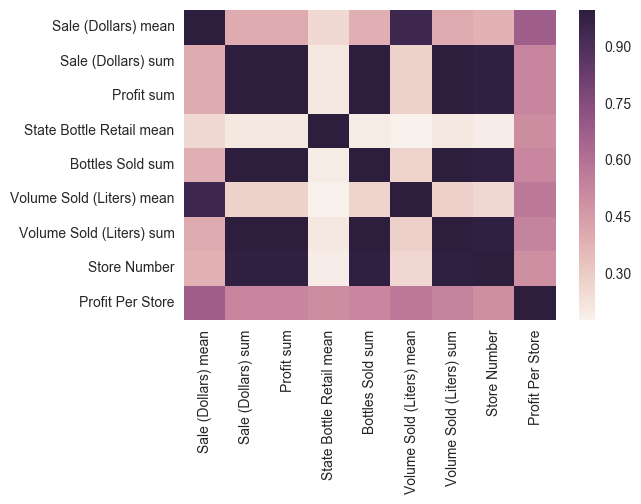

In [230]:
sns.heatmap(County_Table.corr())

The heatmap and correlation tables above do not show any suprising results, with very strong correlations betweens volumes sold, total sales, and profits. One of the possibly more interesting categories is the correlation between the mean alcahole retail price and the profit margin, meaning that states which tend to sell more expensive alcahols also tend to make more then those who perhaps sell a larger volume of cheaper drinks this is enlarged in the graph below.

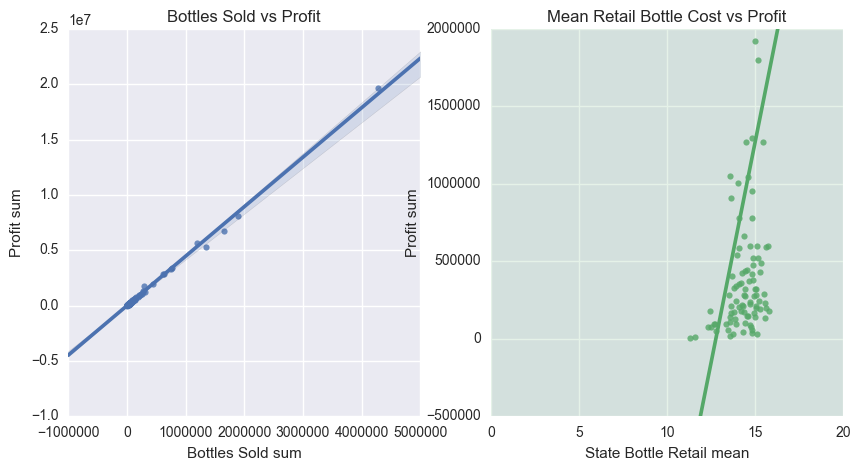

In [262]:
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)     
sns.regplot(County_Table['Bottles Sold sum'],County_Table['Profit sum'],ax=ax1)
sns.regplot(County_Table['State Bottle Retail mean'],County_Table['Profit sum'],ax=ax2)
ax2.set_xlim(0,20)
ax2.set_ylim(-500000,2000000,'log')
ax1.set_title('Bottles Sold vs Profit')
ax2.set_title('Mean Retail Bottle Cost vs Profit')

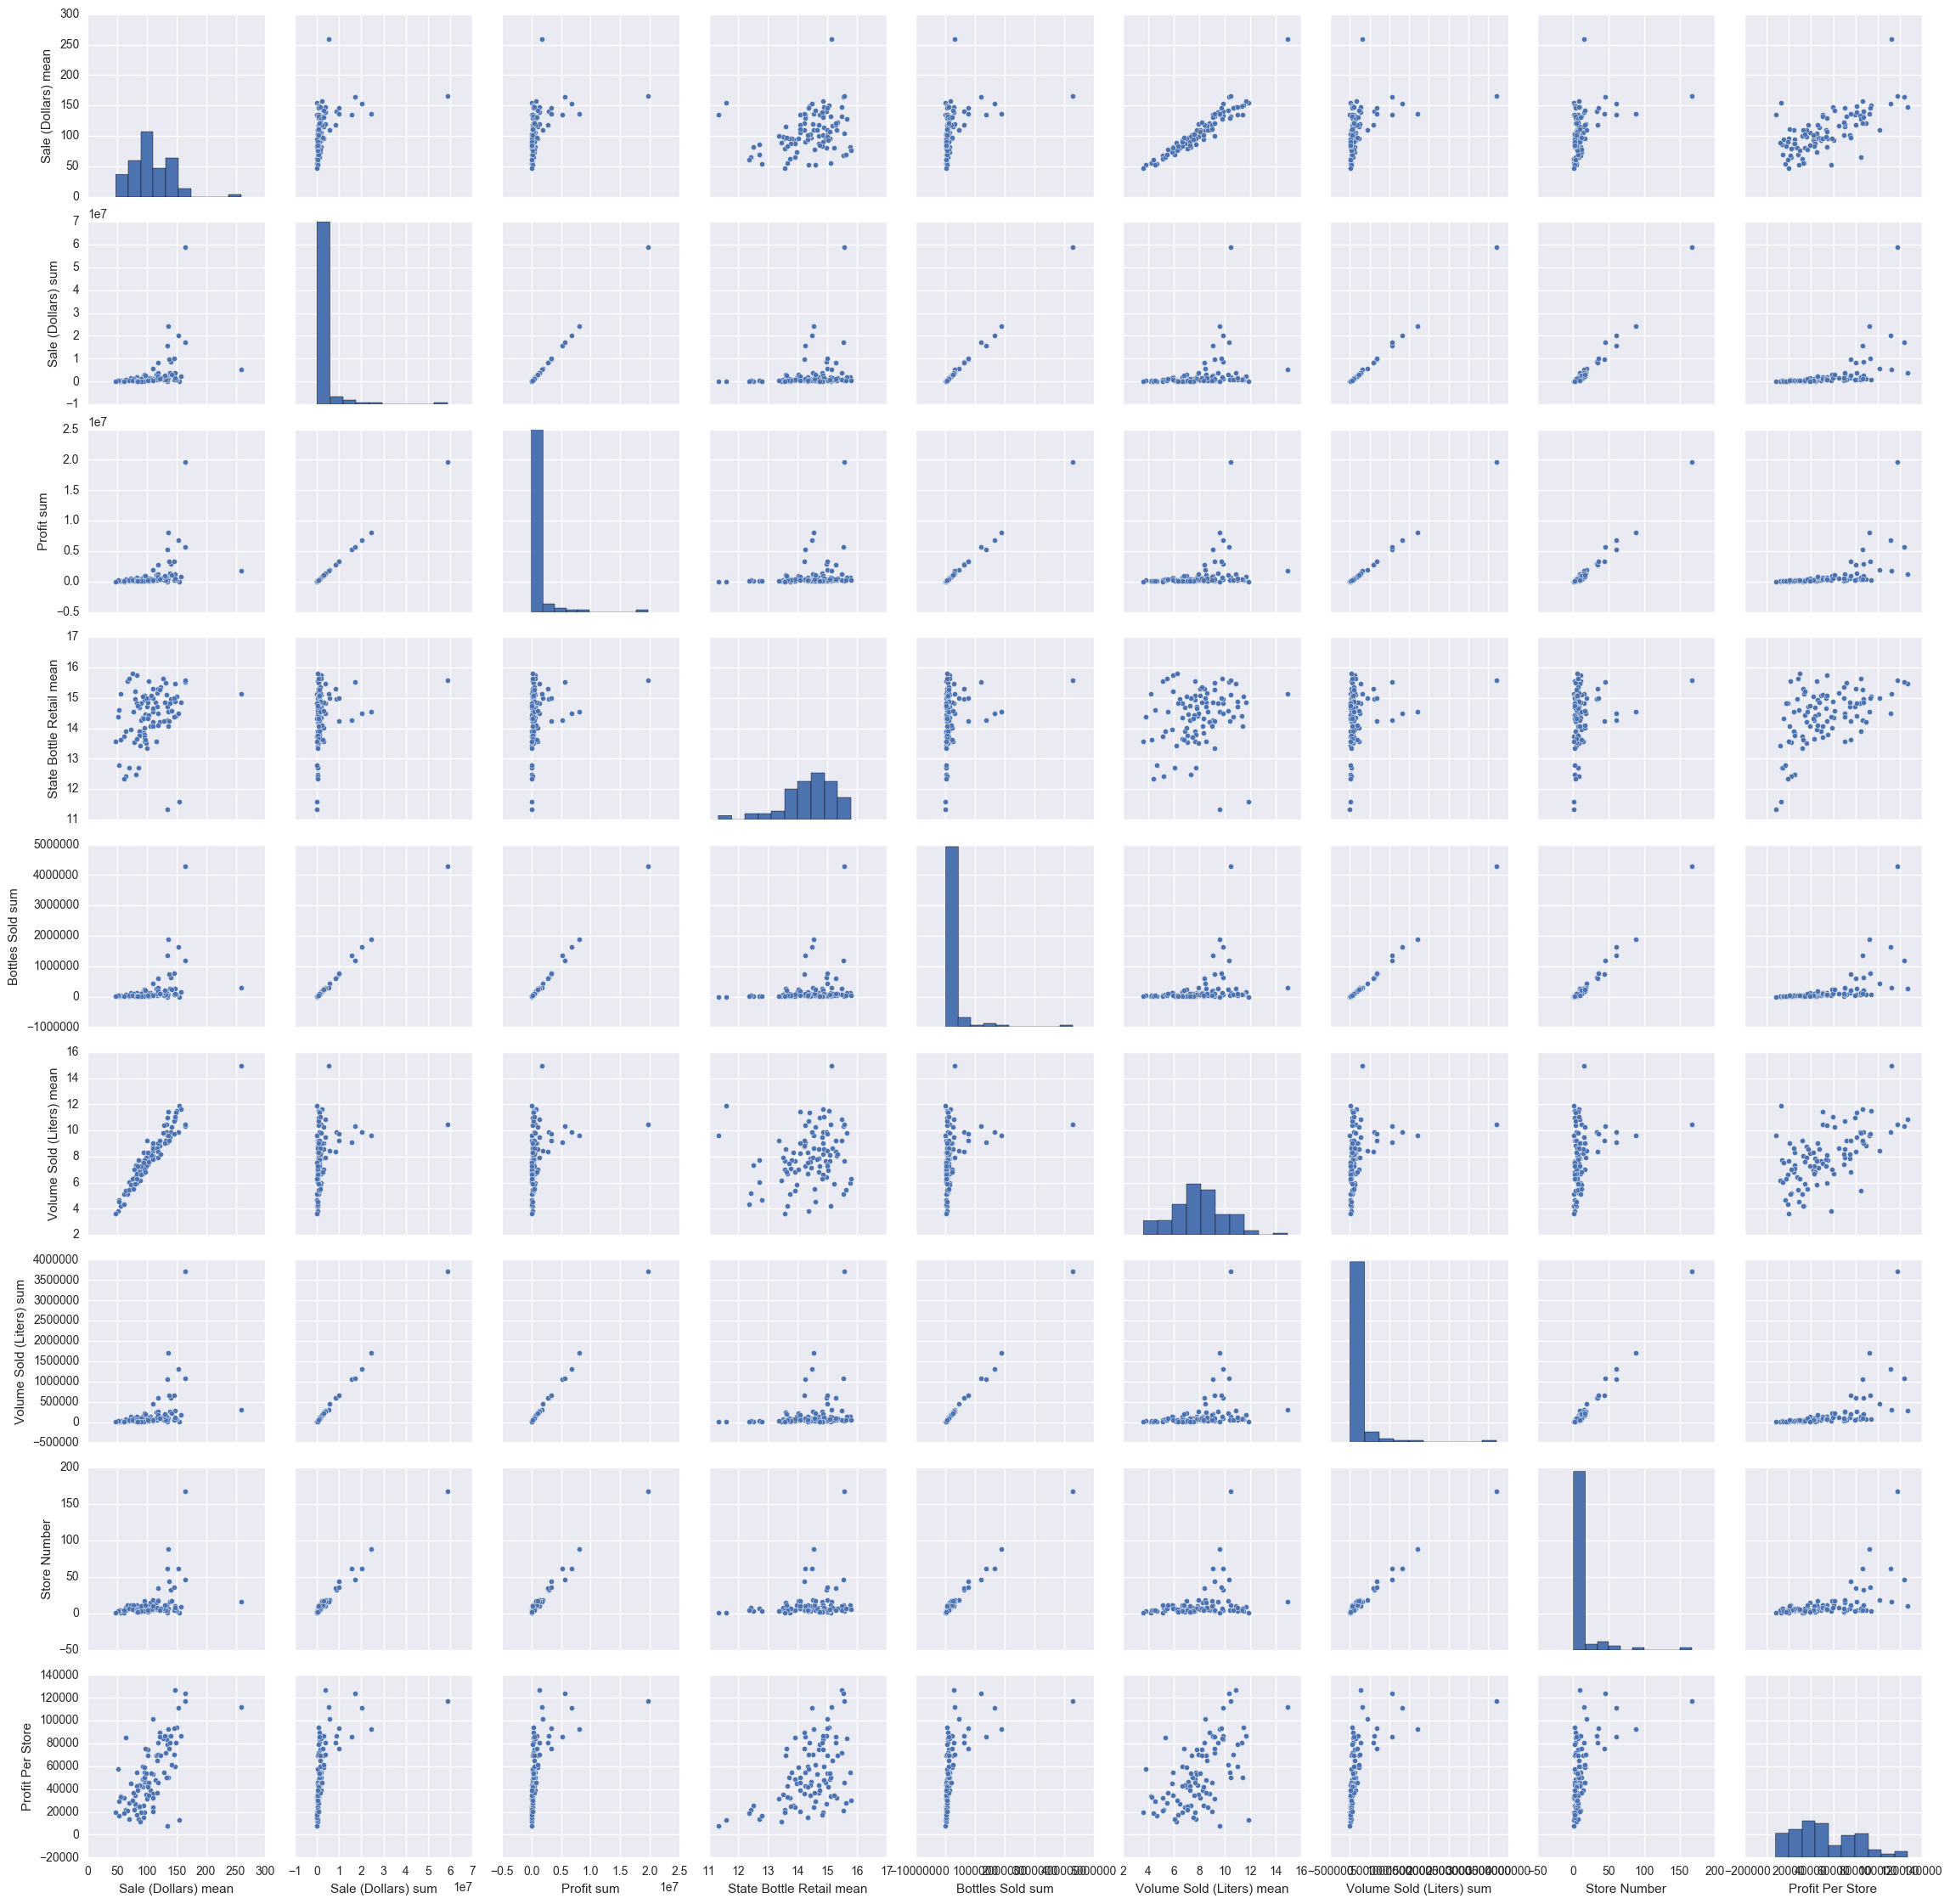

In [231]:
sns.pairplot(County_Table)

The above pairplot is used to visulaise the correlations as well as identifying any possible outliers, these are noticible in the volume/bottles sold charts, and have been isolated below.

In [266]:
print County_Table.sort_values(by='Volume Sold (Liters) sum',ascending=False).head(1)
print '----------'
print County_Table.sort_values(by='Sale (Dollars) sum',ascending=False).head(1)
print '----------'
print County_Table.sort_values(by='Sale (Dollars) mean',ascending=False).head(1)

   County  Sale (Dollars) mean  Sale (Dollars) sum    Profit sum  \
76   Polk           165.284592        5.875289e+07  1.962835e+07   

    State Bottle Retail mean  Bottles Sold sum  Volume Sold (Liters) mean  \
76                 15.570156           4281003                  10.450102   

    Volume Sold (Liters) sum  Store Number  Profit Per Store  
76                3714645.44           167     117535.002275  
----------
   County  Sale (Dollars) mean  Sale (Dollars) sum    Profit sum  \
76   Polk           165.284592        5.875289e+07  1.962835e+07   

    State Bottle Retail mean  Bottles Sold sum  Volume Sold (Liters) mean  \
76                 15.570156           4281003                  10.450102   

    Volume Sold (Liters) sum  Store Number  Profit Per Store  
76                3714645.44           167     117535.002275  
----------
    County  Sale (Dollars) mean  Sale (Dollars) sum  Profit sum  \
24  Dallas           258.822859           5374715.5  1797280.24   

    Sta

Polk county has clearly the highest volume of sales, however stores in Dallis tend to produce more per store, it is likely that Dallis will have one of the highest coefficients from the regression analysis.

In [233]:
#Creating a dummy variables for each County and deleting unneeded columns.
Out_Table_Dummies=pd.get_dummies(Out_Table['County'])
Out_Table_Dummies=Out_Table.join(Out_Table_Dummies)
del Out_Table_Dummies['County']
del Out_Table_Dummies['Zip Code']
del Out_Table_Dummies['Store Number']
del Out_Table_Dummies['City']
del Out_Table_Dummies['Volume Sold (Liters) mean']
del Out_Table_Dummies['Volume Sold (Liters) sum']
#del Out_Table_Dummies['State Bottle Cost']
del Out_Table_Dummies['Sale (Dollars) sum']
del Out_Table_Dummies['Sale (Dollars) mean']
#del Out_Table_Dummies['Profit sum']
#del Out_Table_Dummies['State Bottle Cost']

#The model was tested with various scaleing and normalising options however better results 
#were with out these implemented


#Out_Table_Dummies['Profit sum']=preprocessing.minmax_scale(Out_Table_Dummies['Profit sum'])
#Out_Table_Dummies['State Bottle Retail mean']=preprocessing.minmax_scale(Out_Table_Dummies['State Bottle Retail mean'])
#Out_Table_Dummies['Bottles Sold sum']=preprocessing.minmax_scale(Out_Table_Dummies['Bottles Sold sum'])
Out_Table_Dummies.head()


,Profit sum,State Bottle Retail mean,Bottles Sold sum,Adair,Adams,Allamakee,Appanoose,Audubon,Benton,Black Hawk,...,Wapello,Warren,Washington,Wayne,Webster,Winnebago,Winneshiek,Woodbury,Worth,Wright
0,4900.00,15.866038,964,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,473795.22,16.228941,99034,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,633.21,16.358333,139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,28059.97,15.954162,6344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,6582.09,15.196563,1236,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [234]:
#Create X and Y varibles from the Dummy Varible Dataframe
X=Out_Table_Dummies.drop('Profit sum',axis=1)
y=Out_Table_Dummies['Profit sum']

In [267]:
#Create a training set of 80% of the data.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=10)

r^2: 0.960539254989 MSE:  474199093.816


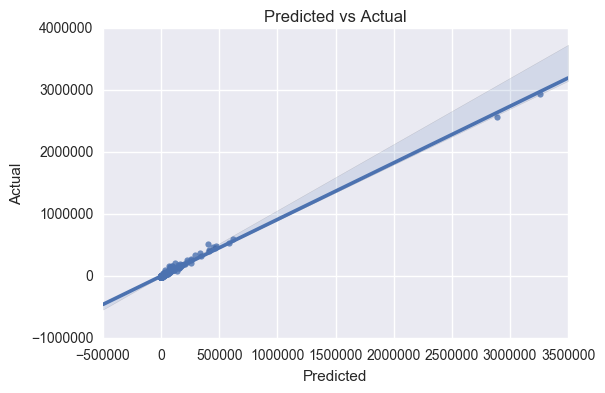

0.985098841235


In [273]:
#As the correlations were quite liner in the exploratory analysis, a monomial liner regression is used to create 
#the model. Initially the linearregression from Sklearn was used, however this was too sensitve to outliers. As the 
#Lasso regression would remove some of the dummy varibles completely, the ridge regression was employed.

from sklearn import linear_model

lm=linear_model.RidgeCV()
model=lm.fit(X_train,y_train)
predictions = model.predict(X_test)
print "r^2:", model.score(X_train, y_train), 'MSE: ', mean_squared_error(y_train, lm.predict(X_train))
Coeff_df=pd.DataFrame({'State':X.columns,'Coefficent':lm.coef_})

fig=plt.figure()
ax1=fig.add_subplot(111)
sns.regplot(y_test, predictions,ax=ax1)
ax1.set_title('Predicted vs Actual')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")
r2 = metrics.r2_score(y_test, predictions)
plt.show()

print r2

The r2 values are very high, as would have been expected due to the high correlations in the exploratory analysis.

In [237]:
#A new csv was created as an output for Tableau in order to map the results. 
Coeff_df.to_csv('County_Coeff.csv')
#The counties with the top 5 coefficients.
Coeff_df.sort_values(by='Coefficent',ascending=False).head(5)

,Coefficent,State
26,13913.472153,Dallas
85,2186.782502,Sioux
100,1860.246833,Wright
47,1846.278817,Humboldt
15,1808.932676,Carroll


Again, as noted in the exploratory analysis, Dallas has produced the highest coefficient by a significant margin. The r2 scores will be cross validated below, over 10 folds to ensure the integrity of the model.

('Cross-validated scores:', array([ 0.8916489 ,  0.96887873,  0.94231185,  0.97154432,  0.92898303,
        0.9667655 ,  0.98733891,  0.98062457,  0.9258104 ,  0.9440365 ]))
('Mean of the cross-validation scores:', 0.95079427134931938)
('Cross-Predicted r2:', 0.95298621471374334)


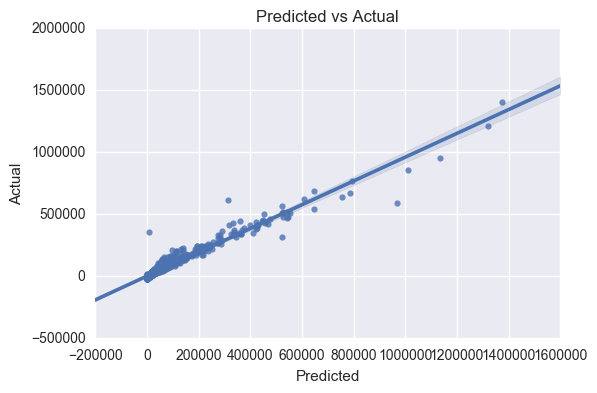

In [272]:
scores = cross_val_score(model, X_train, y_train, cv=10, scoring="r2")
print("Cross-validated scores:", scores)
print("Mean of the cross-validation scores:",np.mean(scores))
# Make cross validated predictions
predictions = cross_val_predict(model, X_train, y_train, cv=10)

# plot
fig=plt.figure()
ax1=fig.add_subplot(111)
sns.regplot(y_train, predictions,ax=ax1)
ax1.set_title('Predicted vs Actual')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")
r2 = metrics.r2_score(y_train, predictions)
print("Cross-Predicted r2:", r2)
plt.show()

The cross predicted r2 results are only very marginally worse then the original model, this validates the model. A OLS model will be created below, in order to see if an improvments can be made, and to further verify the results produced so far.

                            OLS Regression Results                            
Dep. Variable:             Profit sum   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     357.3
Date:                Mon, 31 Oct 2016   Prob (F-statistic):               0.00
Time:                        23:29:07   Log-Likelihood:                -17656.
No. Observations:                1548   AIC:                         3.551e+04
Df Residuals:                    1448   BIC:                         3.605e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
State Bottle Retail mean

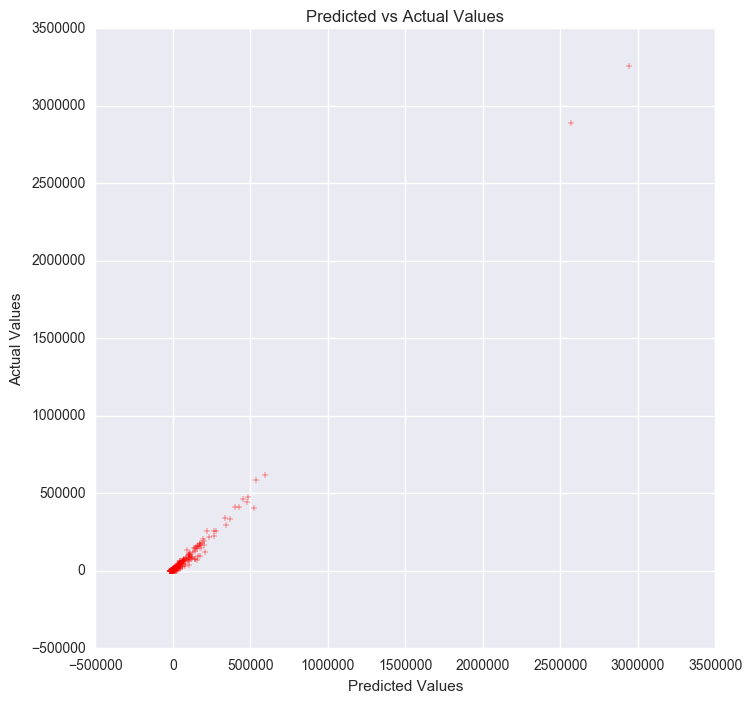

MSE: 505207923.271


In [270]:
import statsmodels.api as sm
model_OLS = sm.OLS(y_train, X_train).fit()
predictions_OLS = model_OLS.predict(X_test)
# Print out the statistics
print model_OLS.summary()

# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions_OLS, y_test, c='r', marker='+')
#plt.axis([0, 50, 0, 50])
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title('Predicted vs Ac')
plt.show()
print "MSE:", model_OLS.mse_resid

The results from the OLS model are very similar to that of the Ridge Linear Regression with Dallis having the highest coefficient, however you can note on the graph the presence of the outliers that skewed the original Linear Regression.

A similar regression analysis was performed on the cities. This is displayed below.

In [240]:
#Creating dummy variables for each city in a new Dataframe
City_Table_Dummies=pd.get_dummies(Out_Table['City'])
City_Table_Dummies=Out_Table.join(City_Table_Dummies)
del City_Table_Dummies['County']
del City_Table_Dummies['Zip Code']
del City_Table_Dummies['Store Number']
del City_Table_Dummies['City']
del City_Table_Dummies['Volume Sold (Liters) mean']
del City_Table_Dummies['Volume Sold (Liters) sum']
#del Out_Table_Dummies['State Bottle Cost']
del City_Table_Dummies['Sale (Dollars) sum']
del City_Table_Dummies['Sale (Dollars) mean']
#del Out_Table_Dummies['Profit sum']
#del Out_Table_Dummies['State Bottle Cost']

#Again the model was tested with various scaleing and normalising options however better results 
#were found without these implemented.

#City_Table_Dummies['Profit sum']=preprocessing.minmax_scale(City_Table_Dummies['Profit sum'])
#City_Table_Dummies['State Bottle Retail mean']=preprocessing.minmax_scale(City_Table_Dummies['State Bottle Retail mean'])
#City_Table_Dummies['Bottles Sold sum']=preprocessing.minmax_scale(City_Table_Dummies['Bottles Sold sum'])
City_Table_Dummies.head()

,Profit sum,State Bottle Retail mean,Bottles Sold sum,ackley,adair,adel,afton,akron,albia,alden,...,west union,wheatland,williamsburg,wilton,windsor heights,winterset,winthrop,woodbine,woodward,zwingle
0,4900.00,15.866038,964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,473795.22,16.228941,99034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,633.21,16.358333,139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28059.97,15.954162,6344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6582.09,15.196563,1236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
#Create target and varible groups
X2=City_Table_Dummies.drop('Profit sum',axis=1)
y2=City_Table_Dummies['Profit sum']
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.2, random_state=10)

r^2: 0.962394793459 MSE:  530989541.009


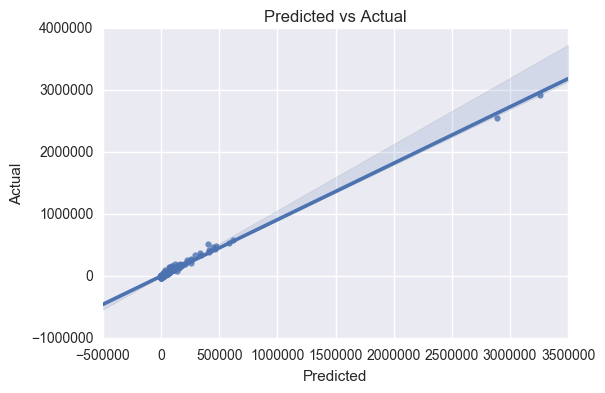

0.984442147629


In [268]:
#Again a Ridge model is used as the Linear Regression was too sensitive to the outliers.
lm2=linear_model.RidgeCV()
model2=lm2.fit(X_train2,y_train2)
predictions2 = model2.predict(X_test2)
print "r^2:", model2.score(X_train2, y_train2), 'MSE: ', mean_squared_error(y2, lm2.predict(X2))
Coeff_df2=pd.DataFrame({'City':X2.columns,'Coefficent':lm2.coef_})

fig=plt.figure()
ax1=fig.add_subplot(111)
sns.regplot(y_test2, predictions2,ax=ax1)
ax1.set_title('Predicted vs Actual')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")
r22 = metrics.r2_score(y_test2, predictions2)
plt.show()
print r22

Again the regression analysis resulted in a very high r2.

In [243]:
#Display the cities with the top 5 coefficient.
Coeff_df2.sort_values(by='Coefficent',ascending=False).head()

,City,Coefficent
368,west des moines,12436.231565
375,windsor heights,9395.716660
71,coralville,7127.868614
33,bettendorf,3942.020499
16,ankeny,1847.682833


In [246]:
#A new DataFrame was created as an output for Tableau in order to map the results. 
#The most common Zip code in each address was used as Tableau could not find all the cities locations.
City_Zip=pd.pivot_table(Out_Table,index='City',aggfunc={'Zip Code':stats.mode})
City_Zip['Zip']=City_Zip['Zip Code'].map(lambda x: str(x[0]).replace("[",''))
City_Zip['Zip']=City_Zip['Zip'].map(lambda x: x.replace("]",''))
City_Zip['Zip']=City_Zip['Zip'].map(lambda x: x.replace("'",''))
del City_Zip['Zip Code']
City_Zip=City_Zip[City_Zip['Zip']!='']
City_Zip=City_Zip.merge(Coeff_df2,left_index=True,right_on='City')
City_Zip['City']=City_Zip['City'].str.title()
City_Zip.to_csv('City_Coeffs.csv')
City_Zip.head(2)

,Zip,City,Coefficent
2,50601,Ackley,510.696513
3,50002,Adair,592.847067


## Results

Below are plots of the counties and cities across Iowa and their cofficients as calcualted by the Ridge analysis. It is clear there is a hot spot around the States Capital of Des Moines in Dallas. This is even more visible the the lower plots which show just the top 5 counties and cities. Where theres is a clear peaking in the region. As the regression scores were very high, there is a clear choice of selecting West Des Monies in Dallis as the optimum choice for a new store location in the region.

<img src='County_Coeff.png'>
<img src='City_Coeff.png'>

<img src='Top_County_Coeff.png'>
<img src='Top_City_Coeff.png'>

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.